In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


### Bivariate Normal Data Generation

In [4]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [4, 3],
    1: [3, 1],
    2: [3, 5],
    3: [2, 4]
}
std = 0.2
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2
}
K = 4
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 1000
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

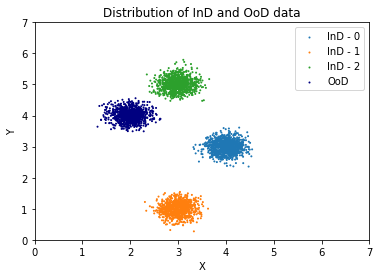

In [565]:
for idx in IND_CLS:
    plt.scatter(IND_X[:,0][IND_Y==idx], IND_X[:,1][IND_Y==idx], label =f"InD - {idx}", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

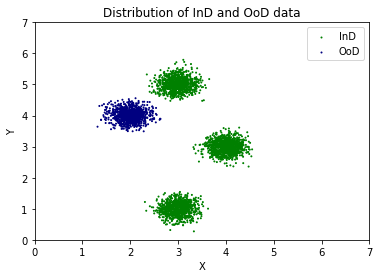

In [566]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [567]:
from tqdm import tqdm
from simulation import classifier_training
D = DSIM()
# Configuration
max_epoch = 256
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

  1%|          | 3/256 [00:00<00:20, 12.46it/s]

Epoch  # 1 | Tri loss: 1.149                     | Tri accuracy: 0.3323
Epoch  # 1 | Val loss: 1.1383                     | Val accuracy: 0.3341


 21%|██        | 53/256 [00:02<00:08, 23.83it/s]

Epoch  # 51 | Tri loss: 0.0343                     | Tri accuracy: 0.9997
Epoch  # 51 | Val loss: 0.0334                     | Val accuracy: 1.0


 41%|████      | 104/256 [00:04<00:06, 23.19it/s]

Epoch  # 101 | Tri loss: 0.0057                     | Tri accuracy: 0.9997
Epoch  # 101 | Val loss: 0.0057                     | Val accuracy: 1.0


 61%|██████    | 155/256 [00:07<00:04, 24.28it/s]

Epoch  # 151 | Tri loss: 0.0023                     | Tri accuracy: 1.0
Epoch  # 151 | Val loss: 0.0024                     | Val accuracy: 1.0


 79%|███████▉  | 203/256 [00:09<00:02, 22.71it/s]

Epoch  # 201 | Tri loss: 0.0013                     | Tri accuracy: 1.0
Epoch  # 201 | Val loss: 0.0013                     | Val accuracy: 1.0


 99%|█████████▉| 254/256 [00:11<00:00, 23.12it/s]

Epoch  # 251 | Tri loss: 0.0008                     | Tri accuracy: 1.0
Epoch  # 251 | Val loss: 0.0008                     | Val accuracy: 1.0


100%|██████████| 256/256 [00:11<00:00, 22.05it/s]


#### Plot

torch.Size([10000, 3])


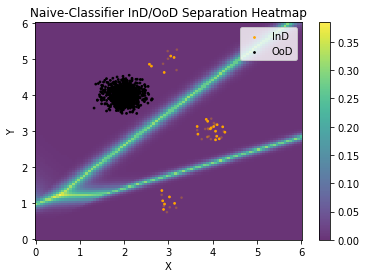

In [568]:
plot_wood = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_X, 
                    D=D, method="Naive-Classifier", m=100)

### WOOD Training

In [32]:
cri = torch.nn.NLLLoss()
a = torch.tensor([[0.99, 0.01]])
a = a.log()
print(cri(a, torch.tensor([1])))

tensor(4.6052)


In [51]:
from simulation import *
D_WOOD = DSIM(64)
# OOD data preparation
n_ood = 128
ood_bsz = 8
OOD_BATCH_0 = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 128
lr = 1e-3
beta = 0.1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH_0, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

OOD Batch Shape: torch.Size([2, 2])


  1%|          | 1/128 [00:01<02:33,  1.21s/it]

Epoch  # 1 | Tri loss: 0.9828                     | Tri accuracy: 0.5919
tensor(0.3015, grad_fn=<WassersteinBackward>)
Epoch  # 1 | Val loss: 0.9166                     | Val accuracy: 0.7852


  9%|▊         | 11/128 [00:10<01:44,  1.12it/s]

Epoch  # 11 | Tri loss: 0.2144                     | Tri accuracy: 1.0
tensor(0.2668, grad_fn=<WassersteinBackward>)
Epoch  # 11 | Val loss: 0.2272                     | Val accuracy: 0.9993


 16%|█▋        | 21/128 [00:19<01:36,  1.10it/s]

Epoch  # 21 | Tri loss: 0.0578                     | Tri accuracy: 1.0
tensor(0.2608, grad_fn=<WassersteinBackward>)
Epoch  # 21 | Val loss: 0.0857                     | Val accuracy: 1.0


 24%|██▍       | 31/128 [00:28<01:25,  1.14it/s]

Epoch  # 31 | Tri loss: 0.019                     | Tri accuracy: 1.0
tensor(0.2567, grad_fn=<WassersteinBackward>)
Epoch  # 31 | Val loss: 0.0453                     | Val accuracy: 1.0


 32%|███▏      | 41/128 [00:36<01:16,  1.14it/s]

Epoch  # 41 | Tri loss: 0.007                     | Tri accuracy: 1.0
tensor(0.2197, grad_fn=<WassersteinBackward>)
Epoch  # 41 | Val loss: 0.0313                     | Val accuracy: 1.0


 40%|███▉      | 51/128 [00:46<01:07,  1.14it/s]

Epoch  # 51 | Tri loss: 0.0024                     | Tri accuracy: 1.0
tensor(0.2449, grad_fn=<WassersteinBackward>)
Epoch  # 51 | Val loss: 0.019                     | Val accuracy: 1.0


 48%|████▊     | 61/128 [00:54<00:57,  1.16it/s]

Epoch  # 61 | Tri loss: -0.0014                     | Tri accuracy: 1.0
tensor(0.2437, grad_fn=<WassersteinBackward>)
Epoch  # 61 | Val loss: 0.0231                     | Val accuracy: 1.0


 55%|█████▌    | 71/128 [01:03<00:50,  1.13it/s]

Epoch  # 71 | Tri loss: -0.004                     | Tri accuracy: 1.0
tensor(0.2562, grad_fn=<WassersteinBackward>)
Epoch  # 71 | Val loss: 0.0129                     | Val accuracy: 1.0


 63%|██████▎   | 81/128 [01:13<00:47,  1.01s/it]

Epoch  # 81 | Tri loss: -0.0068                     | Tri accuracy: 1.0
tensor(0.2482, grad_fn=<WassersteinBackward>)
Epoch  # 81 | Val loss: 0.0156                     | Val accuracy: 1.0


 71%|███████   | 91/128 [01:22<00:32,  1.13it/s]

Epoch  # 91 | Tri loss: -0.0103                     | Tri accuracy: 1.0
tensor(0.2724, grad_fn=<WassersteinBackward>)
Epoch  # 91 | Val loss: 0.015                     | Val accuracy: 1.0


 79%|███████▉  | 101/128 [01:32<00:26,  1.03it/s]

Epoch  # 101 | Tri loss: -0.0128                     | Tri accuracy: 1.0
tensor(0.2451, grad_fn=<WassersteinBackward>)
Epoch  # 101 | Val loss: 0.0105                     | Val accuracy: 1.0


 87%|████████▋ | 111/128 [01:42<00:17,  1.01s/it]

Epoch  # 111 | Tri loss: -0.015                     | Tri accuracy: 1.0
tensor(0.2583, grad_fn=<WassersteinBackward>)
Epoch  # 111 | Val loss: 0.012                     | Val accuracy: 1.0


 95%|█████████▍| 121/128 [01:52<00:06,  1.01it/s]

Epoch  # 121 | Tri loss: -0.0166                     | Tri accuracy: 1.0
tensor(0.2635, grad_fn=<WassersteinBackward>)
Epoch  # 121 | Val loss: 0.0128                     | Val accuracy: 1.0


100%|██████████| 128/128 [01:59<00:00,  1.07it/s]


In [52]:
from simulation import calculate_accuracy
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.95)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.95)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.999)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.999)

0.95: 1.0
0.99: 1.0
0.999: 1.0


0.04410601849109003

### OOD GAN Training

In [53]:
from simulation import *
from wasserstein import *
D_GAN = DSIM(64)
G_GAN = GSIM(64)
# OOD data preparation
# n_ood = 64
ood_bsz = 8
bsz_tri = 64
# OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 128
lr = 1e-4
w_ce, w_wass, w_dist = 1, 0.1, 0.1
n_dim = 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH_0, ood_bsz, bsz_tri, w_ce, w_wass, w_dist,\
                    ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=10)

OOD Batch Shape: torch.Size([2, 2])


  0%|          | 0/128 [00:00<?, ?it/s]

Step: 0    | D:  0.0023 | CE:  0.0167 | W_OoD:  0.1751 | W_z:  0.3074 | G: -0.0030 | W_z:  0.3026 | dist: 0.1864


  0%|          | 0/128 [00:12<?, ?it/s]


KeyboardInterrupt: 

### Plot

#### Plot Naive Classifier

In [593]:
m, n_ind, n_ood = 300, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([90000, 3])


In [594]:
threshold =calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si > threshold

0.99: 0.007000000216066837


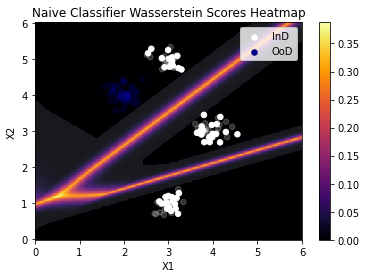

In [595]:
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
n_ind, n_ood = 50, 50, 
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ood, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"Naive Classifier Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example_naive.jpg", dpi=1000)

#### Plot WOOD

In [54]:
m, n_ind, n_ood = 100, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_WOOD(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([10000, 3])


0.99: 1.0


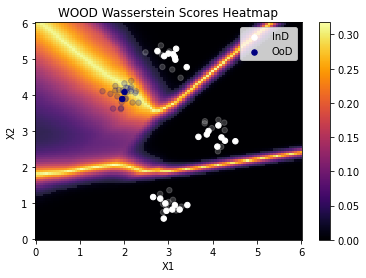

In [55]:
threshold =calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si > threshold
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ind, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"WOOD Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example_wood.jpg", dpi=1000)

#### Plot GAN

In [39]:
m, n_ind, n_ood = 100, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi_gan = torch.softmax(D_GAN(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi_gan.shape)
si_gan = ood_wass_loss(zi_gan)

torch.Size([10000, 3])


In [40]:
threshold =calculate_accuracy(D=D_GAN, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si_gan > threshold

0.99: 1.0


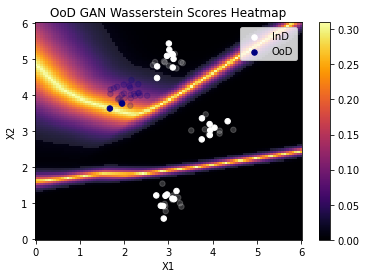

In [41]:
# plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
plt.pcolormesh(xi, yi, si_gan.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ind, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"OoD GAN Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example.jpg", dpi=1000)

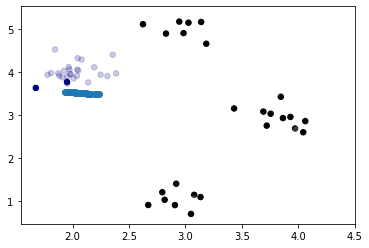

In [38]:
seed = torch.rand((bsz_tri, 2), device=DEVICE)
Gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='black', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.scatter(Gz[:,0], Gz[:,1])

### Save

In [556]:
torch.save(D, "simulation_log/example/D.pt")
torch.save(D_WOOD, "simulation_log/example/D_WOOD.pt")
torch.save(D_GAN, "simulation_log/example/D_GAN.pt")
torch.save(G_GAN, "simulation_log/example/G_GAN.pt")
torch.save(OOD_BATCH,"simulation_log/example/OOD_BATCH.pt")
torch.save(OOD_X,"simulation_log/example/OOD_X.pt")
torch.save(OOD_X_TEST,"simulation_log/example/OOD_X_TEST.pt")
torch.save(IND_X,"simulation_log/example/IND_X.pt")
torch.save(IND_X_TEST,"simulation_log/example/IND_X_TEST.pt")
torch.save(IND_Y,"simulation_log/example/IND_Y.pt")
torch.save(IND_Y_TEST,"simulation_log/example/IND_Y_TEST.pt")
torch.save(SAMPLERS, 'simulation_log/example/samplers.pt')
torch.save((X_TRAIN, Y_TRAIN, X_TEST, Y_TEST), 'simulation_log/example/raw_data.pt')